In [1]:
using LinearAlgebra, OrdinaryDiffEq, SparseArrays
using PlotlyJS
using QuantumToolbox

In [2]:
# set the parameters
N = 3
εd = 0.15
ωd = 0.9
κ = 0.1

# make the operators
a = spdiagm(1 => [sqrt(n) for n in 1:N-1])
# O = spdiagm(1 => ones(N-1), -1 => ones(N-1))
O = a + a'

# make the L0 block
id = I(N)
H0 = sparse(Complex{Float64}[0. 0. 0; 0. 1. 0; 0. 0. 3.])
L0 = -im * (kron(H0, id) - kron(id, transpose(H0))) + κ * (kron(a, conj(a)) - 0.5 * (kron(a' * a, id) + kron(id, transpose(a) * conj(a))))

# make the L_plus and L_minus block
L_plus = -εd/2 * (kron(O, id) - kron(id, transpose(O)))
L_minus = εd/2 * (kron(O, id) - kron(id, transpose(O)));



In [3]:
# make the difference equation matrix
function get_diff_eq_matrix(n_max)
    # size of the final matrix
    s = 2*n_max + 1
    # make diagonals 
    diags = blockdiag([L0 - im * n * ωd * I(N^2) for n in -n_max:n_max]...)

    # make off-diagonals
    upper_hop = kron(spdiagm(1 => ones(s-1)), L_plus)
    lower_hop = kron(spdiagm(-1 => ones(s-1)), L_minus)

    # combine them all
    mat = diags + upper_hop + lower_hop

    return mat
end

get_diff_eq_matrix (generic function with 1 method)

In [12]:
n_max = 4
diff_eq = get_diff_eq_matrix(n_max)

values, vectors = eigsolve(diff_eq; k=4, sigma=1e-6);

In [55]:
# function to plot the wigner function
function plot_wigner(rho,xx,yy)
    layout = Layout(
        xaxis_title="Re(β)",
        yaxis_title="Im(β)",
        title="Wigner function",
        width=500,
        height=500
    )
    
    w = wigner(rho, xx, yy);
    vbound = maximum(abs.(w))

    custom_colorscale = [
        [0, "blue"],   # Negative values to blue
        [0.5, "white"],  # Zero values to white
        [1, "red"],     # Positive values to red
    ]

    heatmap_trace = heatmap(
        z=w,
        x=xx,
        y=yy,
        colorscale=custom_colorscale,
        showscale=true,
        zmin = -vbound,
        zmax = vbound
    )

    plot(heatmap_trace, layout)
end;

In [56]:
# extract the stroboscopic steady state
ρ0 = vec2mat(vectors[1][n_max*N^2:(n_max+1)*N^2-1]);

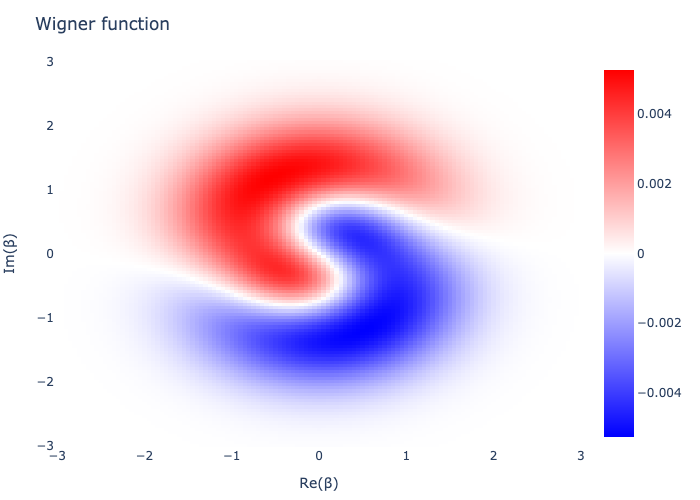

In [57]:
plot_wigner(Qobj(ρ0), -3:0.05:3, -3:0.05:3)

This is the stroboscopic steady state. 

We should compare this to the steady state obtained via mesolve. TODO

Also, compare the performance of this to when we exclude the $\mathcal{L}_0$ term, i.e. when we are in the interaction picture. TODO





In [8]:
# first, solve the system using mesolve

# make the Hamiltonian and collapse operator
H0 = Qobj(spdiagm(0 => [0.0, 1.0, 3.0]))
a = destroy(N)

# make the Hamiltonian associated to L+/- operators
Hp = -εd/2 * (a' + a) / 2
Hm = εd/2 * (a' + a) / 2

# make the evolution object
coef_plus(p, t) = exp(im * p.ωd * t)
coef_minus(p, t) = exp(-im * p.ωd * t)
op = QuantumObjectEvolution((H0, (Hp, coef_plus), (Hm, coef_minus)))

Quantum Object Evo.:   type=Operator   dims=[3]   size=(3, 3)   ishermitian=true   isconstant=false
(MatrixOperator(3 × 3) + ScalarOperator(0.0 + 0.0im) * MatrixOperator(3 × 3) + ScalarOperator(0.0 + 0.0im) * MatrixOperator(3 × 3))

In [9]:
# set time and initial state
tlist = 0:0.1:100

# set the initial state
ρ0 = ket2dm(basis(N, 0))

# mesolve
result = mesolve(op, ρ0, tlist, [sqrt(κ) * a], e_ops=[a], params=(ωd=ωd, εd=εd), saveat=tlist); # small bug -- doesn't work with a single parameter

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)


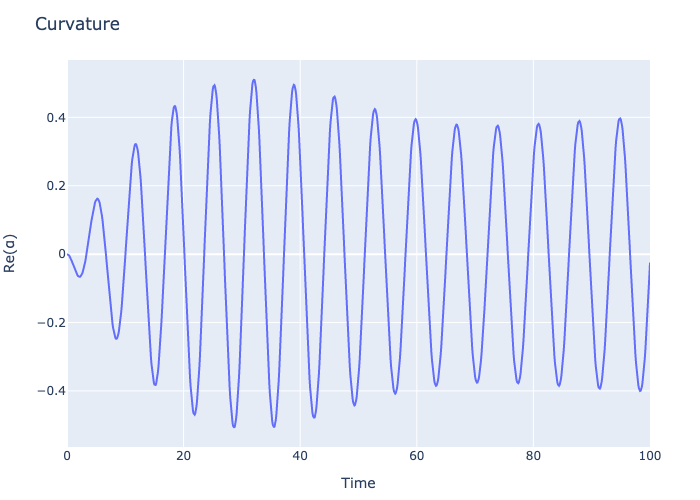

In [10]:
plot_curvature = PlotlyJS.scatter(x=tlist, y=real.(result.expect[:]), name="Re(α)")

plot(plot_curvature, Layout(xaxis_title="Time", yaxis_title="Re(α)", title="Curvature"))

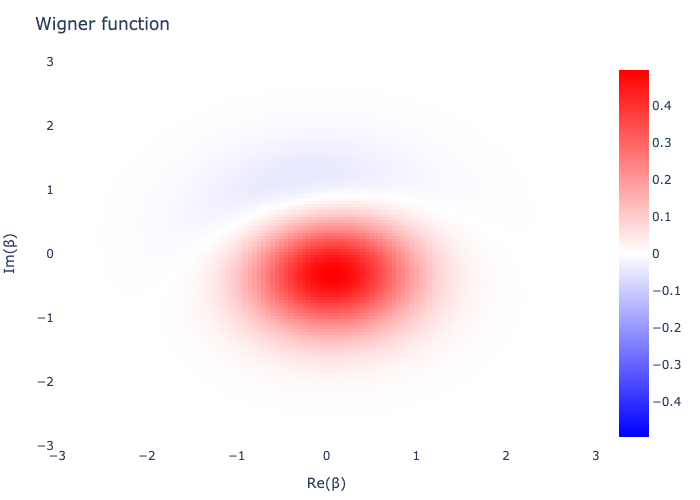

In [58]:
ρ = result.states[end-2]
plot_wigner(ρ, -3:0.05:3, -3:0.05:3)

In [42]:
ρs = result.states
wigners = []
xx = -5:0.05:5
for ρ in ρs
    push!(wigners, wigner(ρ, xx, xx))
end

In [ ]:
using Plots

# Define the parameters and states
Num = length(tlist)

output_folder = "~/Desktop/PhD research/Code and notebooks/simple_phd_codes/plots/"
output_file = joinpath(output_folder, "three_level_system_mesolve.gif")

# Create the GIF
anim = @animate for i in 1:Num
    t = tlist[i]
    Plots.contourf(xx, xx, wigners[i], c=:viridis, title="Wigner function at t=$t", xlabel="Re(β)", ylabel="Im(β)", size=(500, 500))
end
gif(anim, output_file, fps=24);  # Adjust the frame rate as needed


[24324] signal (15): Terminated: 15
in expression starting at /Users/leo/Desktop/PhD research/Code and notebooks/simple_phd_codes/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X63sZmlsZQ==.jl:10
__psynch_cvwait at /usr/lib/system/libsystem_kernel.dylib (unknown line)
unknown function (ip: 0x0)
__psynch_cvwait at /usr/lib/system/libsystem_kernel.dylib (unknown line)
unknown function (ip: 0x0)
__psynch_cvwait at /usr/lib/system/libsystem_kernel.dylib (unknown line)
unknown function (ip: 0x0)
__psynch_cvwait at /usr/lib/system/libsystem_kernel.dylib (unknown line)
unknown function (ip: 0x0)
__psynch_cvwait at /usr/lib/system/libsystem_kernel.dylib (unknown line)
unknown function (ip: 0x0)
__psynch_cvwait at /usr/lib/system/libsystem_kernel.dylib (unknown line)
unknown function (ip: 0x0)
__psynch_cvwait at /usr/lib/system/libsystem_kernel.dylib (unknown line)
unknown function (ip: 0x0)
convert_data_to_bytes at /Users/leo/.julia/artifacts/210d443a7c5fea7d01dd33a1d093d76e47dc9fd5/lib/li

Obviously, the state is not steady. But, it is periodic and therefore steady over the time period $T = 2\pi/\omega_d$. This can also be seen in the curvature which we plot above. 

Now, we take out the $\mathcal{L}_0$ term and compare.

In [ ]:
# make the difference equation matrix
function get_diff_eq_matrix_interaction(n_max)
    # size of the final matrix
    s = 2*n_max + 1
    # make diagonals 
    diags = blockdiag([- im * n * ωd * I(N^2) for n in -n_max:n_max]...)

    # make off-diagonals
    upper_hop = kron(spdiagm(1 => ones(s-1)), L_plus)
    lower_hop = kron(spdiagm(-1 => ones(s-1)), L_minus)

    # combine them all
    mat = diags + upper_hop + lower_hop

    return mat
end

In [113]:
λr, vr = eigsolve(L0; k=N^2,sigma=1e-6);
λl, vl = eigsolve(L0'; k=N^2,sigma=1e-6);

In [ ]:
Pr = zeros(Complex{Float64}, (N^2, N^2))
for i in 1:N^2
    Pr[:, i] = vr[i]
end

Pl = zeros(Complex{Float64}, (N^2, N^2))
for i in 1:N^2
    Pl[:, i] = vl[i]
end

# inv(Pr)' is the same BUT the columns are not normalized for some reason